In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv('../Data/LT_DU_data_for_ML.csv')
data

,nace,lpk,hourly_rate,esize_class_nc,gen_F,gen_M,age_class_nc,education_nc,lpk1,lpk2,lpk1_nc,outlier,nace_nc
0,C,722,8.13,0,0,1,0,1,7,72,478,False,0
1,C,721,8.20,0,0,1,1,1,7,72,478,False,0
2,C,722,8.20,0,0,1,0,1,7,72,478,False,0
3,C,334,2.51,0,1,0,1,1,3,33,300,False,0
4,M,522,2.19,1,1,0,1,1,5,52,500,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36508,N,711,2.84,0,0,1,0,1,7,71,478,False,0
36509,N,711,2.84,0,0,1,0,1,7,71,478,False,0
36510,N,711,2.84,0,0,1,2,1,7,71,478,False,0
36511,N,711,2.84,0,0,1,0,1,7,71,478,False,0


# Data selection and filtering

Select lpk level

In [3]:
lpk_level = 'lpk1'
#Valid options: 'lpk', 'lpk1', 'lpk2', 'lpk1_nc'

Include outliers?

In [4]:
remove_outliers = True
if remove_outliers == True:
    data=data.query('outlier==False')
    print('Outliers removed')
else:
    print('Outliers retained')

data.shape

Outliers removed


(35170, 13)

Remove columns from X and y

In [5]:
remove_col = ['nace_nc', 'lpk', 'lpk1', 'lpk2', 'lpk1_nc', 'outlier']
remove_col.remove(lpk_level)

In [6]:
data_sf = pd.get_dummies(data, prefix=lpk_level ,columns=[lpk_level])
data_sf = pd.get_dummies(data_sf, prefix='nace' ,columns=['nace'])
data_sf.drop(columns=remove_col, inplace=True )
data_sf

,hourly_rate,esize_class_nc,gen_F,gen_M,age_class_nc,education_nc,lpk1_1,lpk1_2,lpk1_3,lpk1_4,...,nace_J,nace_K,nace_L,nace_M,nace_N,nace_O,nace_P,nace_Q,nace_R,nace_S
0,8.13,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8.20,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8.20,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2.51,0,1,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2.19,1,1,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36508,2.84,0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
36509,2.84,0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
36510,2.84,0,0,1,2,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
36511,2.84,0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [7]:
y = data_sf['hourly_rate']
X = data_sf.drop(columns='hourly_rate')
y.shape , X.shape

((35170,), (35170, 31))

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)
y_train.shape, y_test.shape

((28136,), (7034,))

### Model and predictions

In [9]:
""" from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model.fit(X=X_train,y=y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test) """

' from sklearn.linear_model import LinearRegression\nmodel = LinearRegression(fit_intercept=True)\nmodel.fit(X=X_train,y=y_train)\ny_train_pred = model.predict(X_train)\ny_test_pred = model.predict(X_test) '

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
reg1 = RandomForestRegressor(random_state=1)
reg2 = LinearRegression(fit_intercept=True)
model = VotingRegressor(estimators=[('rf', reg1), ('lr', reg2)])
model.fit(X=X_train,y=y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [16]:
def merge_prediction_data(labels, prediction, data):
    """Merge model prediction with initial data based on indexes in train and test sets"""
    df = labels.to_frame()
    df['predicted'] = prediction
    df_w_data = pd.merge(df, data, left_index=True, right_index=True, indicator=False)
    df_w_data.rename(columns={'hourly_rate_x':'hourly_rate'}, inplace=True)
    df_w_data.drop(columns='hourly_rate_y', inplace=True)
    df_w_data['residuals'] =  df_w_data['predicted'] -  df_w_data['hourly_rate']
    return df_w_data

In [19]:
train=merge_prediction_data(y_train, y_train_pred, data)
test=merge_prediction_data(y_test, y_test_pred, data)

In [13]:
print('Train: RMSE=', np.sqrt(mean_squared_error(train['hourly_rate'], train['predicted'])).round(2),
    ' R2=', r2_score(train['hourly_rate'], train['predicted']).round(2))

print('Test: RMSE=', np.sqrt(mean_squared_error(test['hourly_rate'], test['predicted'])).round(2),
    ' R2=', r2_score(test['hourly_rate'], test['predicted']).round(2))

Train: RMSE= 1.93  R2= 0.52
Test: RMSE= 2.0  R2= 0.47


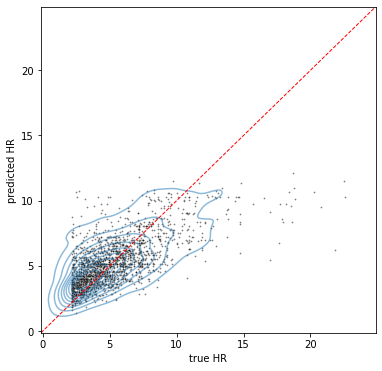

In [14]:
plot_data=test.sample(frac=0.3)
plt.figure(figsize = (6,6))
sns.scatterplot(data=plot_data, x='hourly_rate', y='predicted',  s=3, color='black', alpha=0.5)
sns.kdeplot(data=plot_data, x='hourly_rate', y='predicted', alpha=0.5 )
plt.ylim(plt.xlim())
plt.xlabel('true HR')
plt.ylabel('predicted HR')
plt.plot(plt.ylim(), plt.ylim(), linestyle='--', color='r', lw=1, scalex=False, scaley=False);

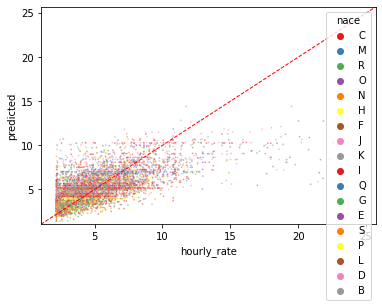

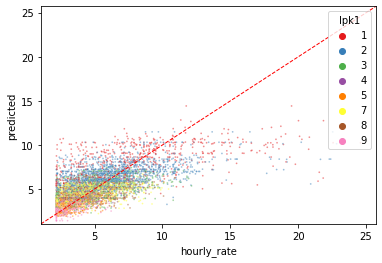

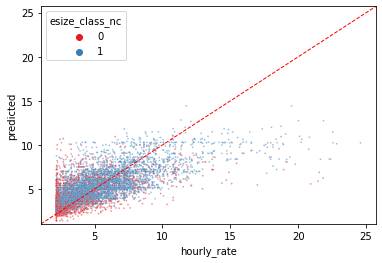

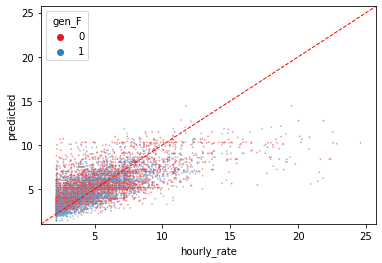

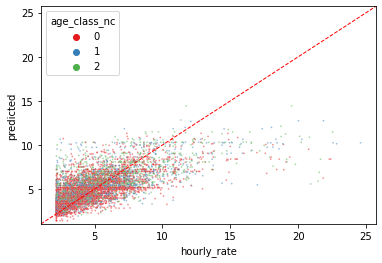

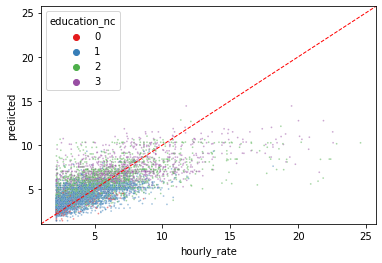

In [15]:
for feature in ['nace', 'lpk1',  'esize_class_nc', 'gen_F', 'age_class_nc', 'education_nc']:
    sns.scatterplot(data=test, x='hourly_rate', y='predicted', s=3, hue=feature, alpha=0.5, palette='Set1')
    plt.ylim(plt.xlim())
    plt.plot(plt.xlim(), plt.ylim(), linestyle='--', color='r', lw=1, scalex=False, scaley=False)
    plt.show();


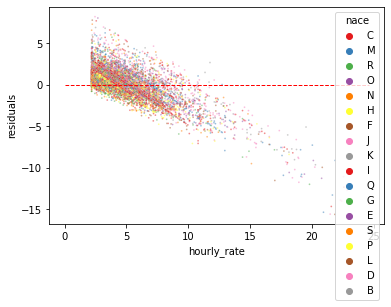

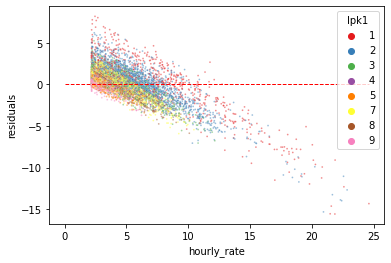

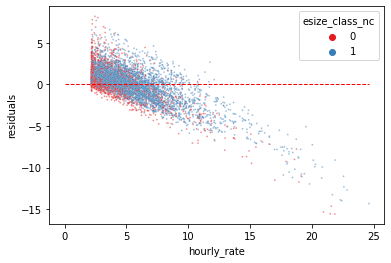

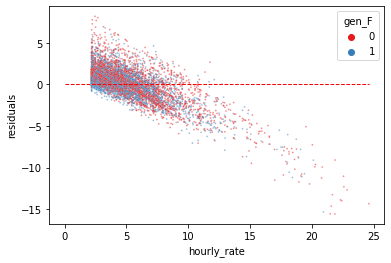

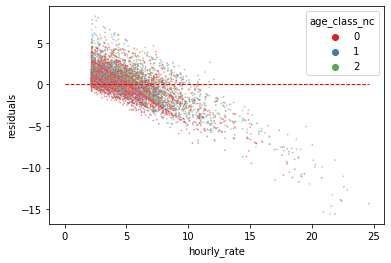

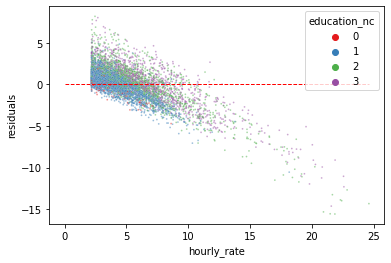

In [30]:
for feature in ['nace', 'lpk1',  'esize_class_nc', 'gen_F', 'age_class_nc', 'education_nc']:
    sns.scatterplot(data=test, x='hourly_rate', y='residuals', s=3, hue=feature, alpha=0.5, palette='Set1')
    plt.hlines(xmin=0, xmax=max(test['hourly_rate']) , y=0, linestyle='--', color='r', lw=1)
    plt.show();